## Dependency

In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import callbacks
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models

## Seeds

In [2]:
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

## Connect GPU

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')

if physical_devices:
    print("GPU found, using it!")
    tf.config.set_visible_devices(physical_devices[0], 'GPU')  
else:
    print("No GPU found, using CPU.")
    tf.config.set_visible_devices([], 'GPU') 


No GPU found, using CPU.


## Constants

In [4]:
IMG_SIZE = 340  
BATCH_SIZE = 16
LEARNING_RATE = 5e-5
EPOCHS = 15
CLASS_LABELS = ("0", "1")
CLASS_NAMES = ["Artifact", "No Artifact"]
LABEL_MAP = {0: 'Artifact', 1: 'No Artifact'}
MODEL_CONFIGS = [
    {'conv_filters': [16, 32, 64], 'dropout_rate': 0.5, "fc_units": 256, "padding": "valid"}
]


## Paths

In [5]:
root_path = os.path.abspath(os.path.join('..'))
data_path = os.path.join(root_path, "data")
models_path = os.path.join(root_path, "models")

## Custom metric

In [6]:
class MicroF1(tf.keras.metrics.Metric):
    def __init__(self, name='micro_f1', threshold=0.5, **kwargs):
        super().__init__(name=name, **kwargs)
        self.threshold = threshold
        self.tp = self.add_weight(name='tp', initializer='zeros', dtype=tf.float32)
        self.fp = self.add_weight(name='fp', initializer='zeros', dtype=tf.float32)
        self.fn = self.add_weight(name='fn', initializer='zeros', dtype=tf.float32)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > self.threshold, tf.float32)
        y_true = tf.cast(y_true, tf.float32)
        
        tp = tf.reduce_sum(y_true * y_pred)
        fp = tf.reduce_sum((1.0 - y_true) * y_pred)
        fn = tf.reduce_sum(y_true * (1.0 - y_pred))
        
        self.tp.assign_add(tp)
        self.fp.assign_add(fp)
        self.fn.assign_add(fn)

    def result(self):
        precision = self.tp / (self.tp + self.fp + tf.keras.backend.epsilon())
        recall = self.tp / (self.tp + self.fn + tf.keras.backend.epsilon())
        return 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())

    def reset_states(self):
        self.tp.assign(0.0)
        self.fp.assign(0.0)
        self.fn.assign(0.0)

## Models

In [7]:
def build_cnn(
    input_shape=(256, 256, 3),
    conv_filters=[32, 64],
    kernel_size=3,
    dropout_rate=0.5,
    fc_units=128,
    padding="valid",
    normalization=False
):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))

    for conv_filter in conv_filters:
        model.add(layers.Conv2D(conv_filter, kernel_size=kernel_size, padding=padding, activation='relu'))
        if normalization:
            model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(fc_units, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

## Load data

In [8]:
def load_dataset(data_dir, class_labels):
    supported_formats = ('.png', '.jpg', '.jpeg')
    records = []

    for label in class_labels:
        folder = os.path.join(data_dir, label)
        if not os.path.isdir(folder):
            continue
        for fname in os.listdir(folder):
            if fname.lower().endswith(supported_formats): 
                records.append({
                    'image_path': os.path.join(folder, fname),
                    'label': int(label)
                })

    return pd.DataFrame(records)

In [9]:
train_df = load_dataset(os.path.join(data_path, "train"), CLASS_LABELS)
test_df = load_dataset(os.path.join(data_path, "test"), CLASS_LABELS)

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

Train shape: (1800, 2)
Test shape: (200, 2)


## Split Data

### Split training data for validation


In [10]:
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42)

print(f"Training set: {len(train_df)} images")
print(f"Validation set: {len(val_df)} images")
print(f"Test set: {len(test_df)} images")

Training set: 1440 images
Validation set: 360 images
Test set: 200 images


## Preprocess data

In [11]:
def load_image(img_path, label):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    return img, label

In [12]:
def preprocess_image(img, label, img_size, augment=False):
    img = tf.image.resize(img, [img_size, img_size])

    if augment:
        # Random lighting changes
        img = tf.image.random_brightness(img, max_delta=0.3)
        img = tf.image.random_contrast(img, lower=0.5, upper=1.5)
        img = tf.image.random_saturation(img, lower=0.6, upper=1.4)
        img = tf.image.random_hue(img, max_delta=0.05)

        # Random reflections
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)

        # Random rotation
        img = tf.image.rot90(img, k=tf.random.uniform(shape=[], minval=0, maxval=3, dtype=tf.int32))

        # Random zoom
        scales = tf.random.uniform([], 0.9, 1.1)
        new_size = tf.cast(tf.cast(tf.shape(img)[:2], tf.float32) * scales, tf.int32)
        img = tf.image.resize(img, new_size)
        img = tf.image.resize_with_crop_or_pad(img, img_size, img_size)

    return img, label


In [13]:
def build_dataset(df, img_size, augment=False):
    paths = df['image_path'].values
    labels = df['label'].values
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))

    loaded_dataset = dataset.map(load_image)

    preprocessed_dataset = loaded_dataset.map(lambda img, label: preprocess_image(img, label, img_size, augment), 
                          num_parallel_calls=tf.data.AUTOTUNE)

    return preprocessed_dataset

In [39]:
def create_dataset(df, batch_size, img_size, augment=False):
    dataset = build_dataset(df, img_size, augment=augment)
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
def create_balance_dataset(df, batch_size, img_size, is_training=False):
    class_0 = df[df['label'] == 0]
    class_1 = df[df['label'] == 1]

    if len(class_0) > len(class_1):
        majority, minority = class_0, class_1
    else:
        majority, minority = class_1, class_0

    majority_count = len(majority)
    minority_count = len(minority)
    repeat_factor = (majority_count // minority_count) - 1

    majority_ds = build_dataset(majority, img_size, augment=False)
    minority_ds_list = [build_dataset(minority, img_size, augment=False)]

    for _ in range(repeat_factor):
        minority_ds_list.append(build_dataset(minority, img_size, augment=True))

    balanced_ds = majority_ds
    for ds in minority_ds_list:
        balanced_ds = balanced_ds.concatenate(ds)

    if is_training:
        total_size = majority_count + minority_count * (repeat_factor + 1)
        balanced_ds = balanced_ds.shuffle(buffer_size=total_size)

    return balanced_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

### Create datasets and balance train data

In [15]:
train_ds = create_balance_dataset(train_df, BATCH_SIZE, IMG_SIZE,is_training=True)
val_ds = create_balance_dataset(val_df, BATCH_SIZE, IMG_SIZE)
test_ds = create_balance_dataset(test_df, BATCH_SIZE, IMG_SIZE)

## Train

In [16]:
def train_model(model, train_ds, val_ds, epochs=10, learning_rate=1e-4):    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            MicroF1()
        ]
    )

    early_stopping = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[
            early_stopping
        ]
    )
    
    return history

In [17]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['micro_f1'], label='Training Micro F1')
    plt.plot(history.history['val_micro_f1'], label='Validation Micro F1')
    plt.title('Micro F1')
    plt.xlabel('Epoch')
    plt.ylabel('Micro F1')
    plt.legend()
    
    
    plt.tight_layout()
    plt.show()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 338, 338, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 169, 169, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 167, 167, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 83, 83, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 81, 81, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 102400)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    26,214,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,238,497 (100.09 MB)

 Trainable params: 26,238,497 (100.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
162/162 ━━━━━━━━━━━━━━━━━━━━ 105s 519ms/step - accuracy: 0.6577 - loss: 14.1667 - micro_f1: 0.5134 - precision: 0.6553 - recall: 0.6613 - val_accuracy: 0.8704 - val_loss: 0.3101 - val_micro_f1: 0.8821 - val_precision: 0.8109 - val_recall: 0.9660
Epoch 2/15
162/162 ━━━━━━━━━━━━━━━━━━━━ 106s 542ms/step - accuracy: 0.8663 - loss: 0.3326 - micro_f1: 0.5224 - precision: 0.8519 - recall: 0.8808 - val_accuracy: 0.9028 - val_loss: 0.2767 - val_micro_f1: 0.9049 - val_precision: 0.8850 - val_recall: 0.9259
Epoch 3/15
162/162 ━━━━━━━━━━━━━━━━━━━━ 106s 543ms/step - accuracy: 0.8879 - loss: 0.2838 - micro_f1: 0.5245 - precision: 0.8798 - recall: 0.8946 - val_accuracy: 0.8997 - val_loss: 0.2326 - val_micro_f1: 0.8935 - val_precision: 0.9246 - val_recall: 0.8704
Epoch 4/15
162/162 ━━━━━━━━━━━━━━━━━━━━ 100s 509ms/step - accuracy: 0.9084 - loss: 0.2287 - micro_f1: 0.5335 - precision: 0.8970 - recall: 0.9242 - val_accuracy: 0.9259 - val_loss: 0.2020 - val_micro_f1: 0.9274 - val_precision: 0.8

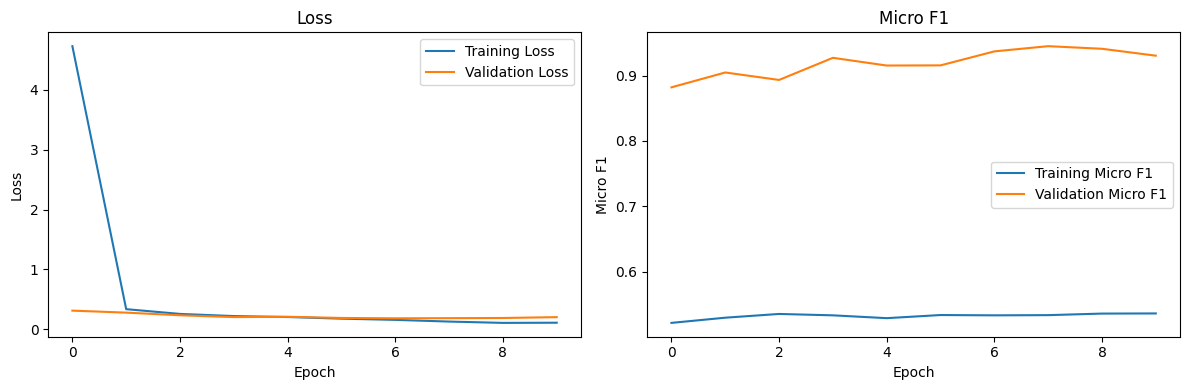

In [18]:
histories = []
trained_models = []

for config in MODEL_CONFIGS:
    model = build_cnn(input_shape=(IMG_SIZE, IMG_SIZE, 3), **config)
    model.summary()

    history = train_model(model, train_ds, val_ds, EPOCHS, LEARNING_RATE)

    histories.append(history)
    trained_models.append(model)
    plot_training_history(history)



## Validation

In [19]:
def visualize_predictions(model, test_df, label_map, num_samples=8):        
    sample_indexes = np.random.choice(len(test_df), min(num_samples, len(test_df)), replace=False)
    
    _, axes = plt.subplots(2, num_samples // 2, figsize=(15, 6))
    axes = axes.flatten()
    
    for i, idx in enumerate(sample_indexes):
        img_path = test_df.iloc[idx]['image_path']
        true_label = test_df.iloc[idx]['label']
        
        # Load and resize image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        
        # Get prediction
        img_tensor = tf.expand_dims(img / 255.0, 0)
        pred = model.predict(img_tensor)[0][0]
        pred_class = 1 if pred > 0.5 else 0
        
        # Display
        axes[i].imshow(img)
        color = "green" if pred_class == true_label else "red"
        title = f"True: {label_map[true_label]}\nPred: {label_map[pred_class]} ({pred:.2f})"
        axes[i].set_title(title, color=color)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

In [20]:
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(6, 5))
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    thresh = cm.max() / 2
    for i in range(len(cm)):
        for j in range(len(cm[0])):
            plt.text(j, i, f"{cm[i, j]}", ha='center', 
                     color='white' if cm[i, j] > thresh else 'black')

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [54]:
def evaluate_model(model, test_ds, class_labels,):
    preds, labels = [], []
    for x, y in test_ds:
        y_pred = model.predict(x) > 0.5
        preds.extend(y_pred.astype(int).flatten())
        labels.extend(y.numpy())

    f1 = f1_score(labels, preds, average='micro')
    print(f"Micro F1 Score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(labels, preds))

    cm = confusion_matrix(labels, preds)
    plot_confusion_matrix(cm, class_labels)

    return {
        'f1_micro': f1,
        'confusion_matrix': cm,
        'true_labels': labels,
        'predictions': preds
    }

In [22]:
def find_best_model(histories, models, val_ds):
    val_f1_scores = []
    for i, model in enumerate(models):
        results = model.evaluate(val_ds, verbose=0)
        val_f1 = results[4] if len(results) > 4 else 0 
        val_f1_scores.append(val_f1)
        print(f"Model {i+1} - Validation F1: {val_f1:.4f}")
    
    best_model_idx = val_f1_scores.index(max(val_f1_scores))
    print(f"Best model: Model {best_model_idx+1} with validation F1: {val_f1_scores[best_model_idx]:.4f}")
    
    return models[best_model_idx], histories[best_model_idx], best_model_idx

In [23]:
best_model, best_history, best_model_idx = find_best_model(histories, trained_models, val_ds)

Model 1 - Validation F1: 0.9379
Best model: Model 1 with validation F1: 0.9379


In [37]:
test_ds = create_balance_dataset(test_df, BATCH_SIZE, IMG_SIZE)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Micro F1 Score: 0.9472

Classification Report:
              precision    recall  f1-score   support

  

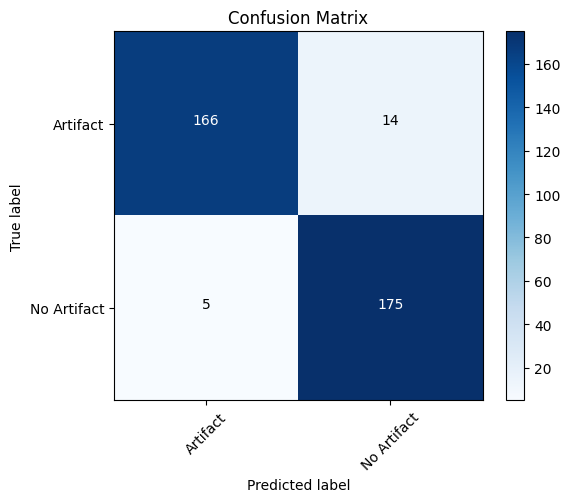

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


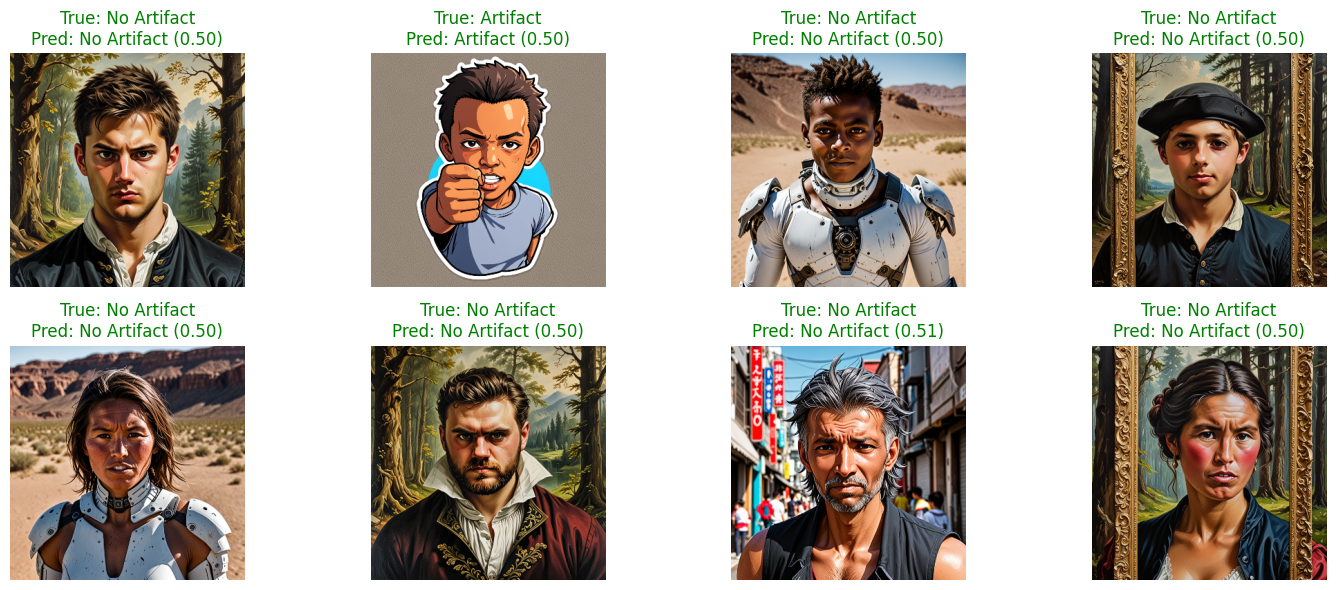

  Micro F1: 0.9472


In [55]:
test_results = evaluate_model(best_model, test_ds, CLASS_NAMES)
visualize_predictions(model, test_df, LABEL_MAP)

print(f"  Micro F1: {test_results['f1_micro']:.4f}")

In [25]:
best_model_path = os.path.join(models_path, f"best_model_{best_model_idx+1}.keras")
best_model.save(best_model_path)
print(f"\nBest model saved to: {best_model_path}")


Best model saved to: d:\IT-JIM-Trainee\Binary-classification\models\best_model_1.keras


## Infer

In [52]:
def detect_artifacts(model, image_path):
    try:
        img = cv2.imread(image_path)

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img / 255.0
        img = np.expand_dims(img, axis=0)
        
        pred = model.predict(img)[0][0]
        pred_class = 1 if pred > 0.5 else 0
        
        result = {
            'prediction': CLASS_NAMES[pred_class],
            'confidence': float(pred if pred_class == 1 else 1 - pred),
            'raw_score': float(pred)
        }
        
        return result
    except Exception as e:
        return {'error': str(e)}

In [53]:
def visualize_inference(model, image_path):
    result = detect_artifacts(model, image_path)
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.title(f"Prediction: {result['prediction']} (Confidence: {result['confidence']:.2f})")
    plt.axis('off')
    plt.show()
    
    print(f"Raw prediction score: {result['raw_score']:.4f}")
    print(f"Predicted class: {result['prediction']}")
    print(f"Confidence: {result['confidence']:.4f}")

### Load the best model for inference

In [28]:
model_path = f"best_model_{best_model_idx+1}.keras"

In [29]:
loaded_model = tf.keras.models.load_model(
    os.path.join(models_path, model_path),
    custom_objects={'MicroF1': MicroF1}
)
print("Model loaded")

Model loaded


### Run inference on some test samples



Sample 20 (True label: Artifact)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


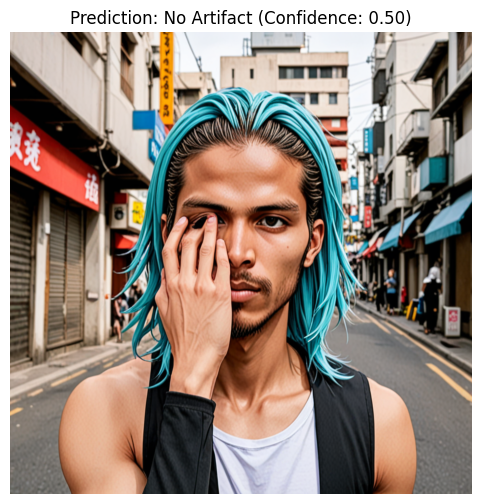

Raw prediction score: 0.5013
Predicted class: No Artifact
Confidence: 0.5013

Sample 19 (True label: Artifact)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


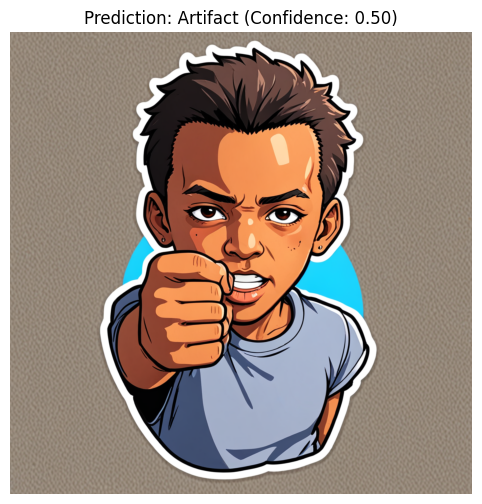

Raw prediction score: 0.4998
Predicted class: Artifact
Confidence: 0.5002

Sample 6 (True label: Artifact)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


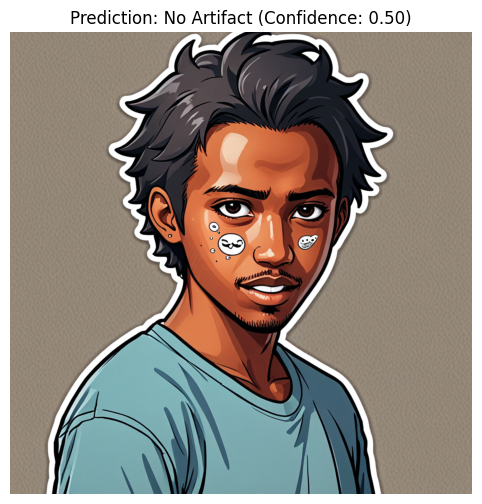

Raw prediction score: 0.5048
Predicted class: No Artifact
Confidence: 0.5048

Sample 43 (True label: No Artifact)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


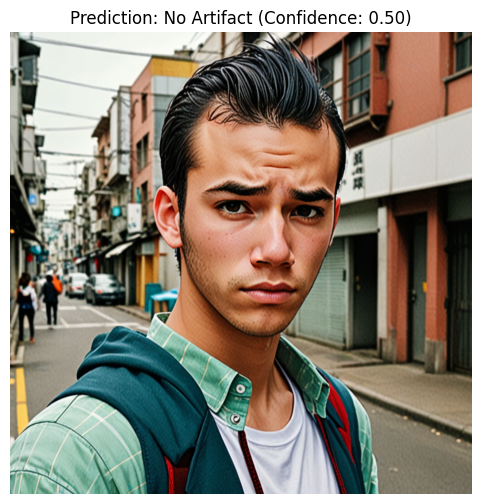

Raw prediction score: 0.5012
Predicted class: No Artifact
Confidence: 0.5012

Sample 49 (True label: No Artifact)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


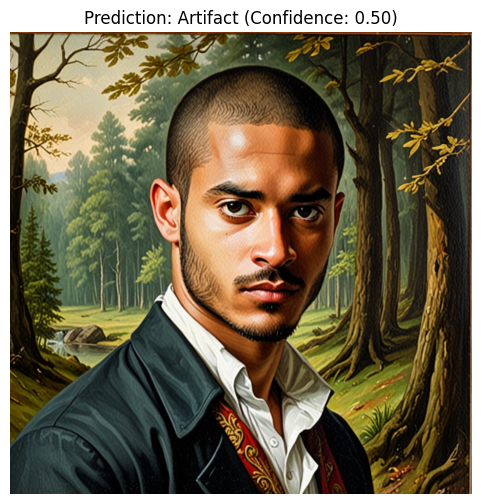

Raw prediction score: 0.4995
Predicted class: Artifact
Confidence: 0.5005

Sample 108 (True label: No Artifact)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


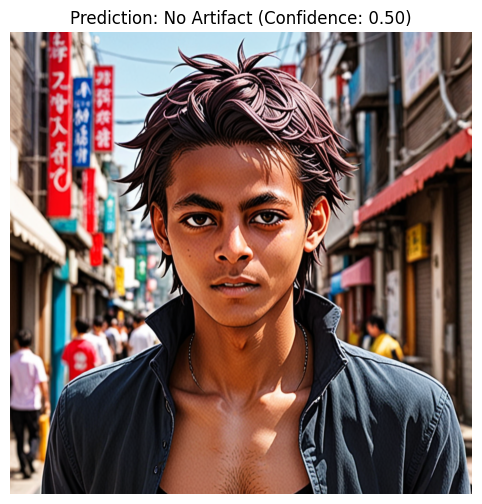

Raw prediction score: 0.5050
Predicted class: No Artifact
Confidence: 0.5050


In [56]:
if len(test_df) > 0:
    artifact_samples = test_df[test_df['label'] == 0].sample(min(3, len(test_df[test_df['label'] == 0])))
    no_artifact_samples = test_df[test_df['label'] == 1].sample(min(3, len(test_df[test_df['label'] == 1])))
    
    for i, row in pd.concat([artifact_samples, no_artifact_samples]).iterrows():
        print(f"\nSample {i+1} (True label: {CLASS_NAMES[row['label']]})")
        visualize_inference(loaded_model, row['image_path'])

## Conclusion

### Key Aspects of the Solution
1. **Data balancing**: Used augmentation to balance class distribution
2. **Custom metrics**: Implemented Micro F1 score for better evaluation
3. **Model selection**: Compared multiple model configurations and selected the best one
4. **Data augmentation**: Applied brightness, contrast, rotation, and zoom augmentations
5. **Early stopping**: Prevented overfitting by monitoring validation loss

### Future Improvements
- Try focal loss
- Use pre-trained model
- Implement more sophisticated data augmentation techniques
- Apply cross-validation for more robust evaluation
- Test ensemble methods with different config to improve performance